In [ ]:
import pandas as pd
import yfinance as yf

df = pd.read_csv('../datasets/INFY-without-closing-price.csv', index_col=False)
df.set_index("INFY", inplace=True)
df

ticker = yf.download('INFY.NS', start="2004-03-01", end="2024-10-01", interval="1mo")

ticker.index = pd.to_datetime(ticker.index)

ticker = ticker[ticker.index.month.isin([3, 6, 9, 12])]

ticker = ticker.T

ticker.columns = df.columns

df = pd.concat([ticker, df])

df.to_csv("../datasets/INFY.csv")

In [ ]:
import pandas pd
df = pd.read_csv("../datasets/INFY-ratios.csv")
df.set_index('INFY', inplace=True)
df = df.T
def repeat_values(df):
    repeated_df = df.applymap(lambda x: [x] * 4)
    repeated_df = pd.DataFrame({
        col: [val for sublist in repeated_df[col] for val in sublist]
        for col in repeated_df.columns
    })
    return repeated_df

repeated_df = repeat_values(df)
repeated_df = repeated_df.T

def generate_columns(start_year, end_year):
    columns = []
    for year in range(start_year, end_year + 1):
        for month in ['Mar', 'Jun', 'Sep', 'Dec']:
            columns.append(f"{month} {year}")
    return columns

column_names = generate_columns(4, 24)

repeated_columns = pd.DataFrame(columns=column_names)

repeated_df.columns = repeated_columns.columns

repeated_df.drop("Sep 24", axis=1, inplace=True)
repeated_df.drop("Dec 24", axis=1, inplace=True)

repeated_df.to_csv("../datasets/INFY-ratios.csv")

In [ ]:
import pandas as pd

df = pd.read_csv("../datasets/INFY-quarterly-data.csv")
df.set_index('INFY', inplace=True)

dfw.drop("Jun '03", axis=1, inplace=True)
dfw.drop("Sep '03", axis=1, inplace=True)
dfw.drop("Dec '03", axis=1, inplace=True)

dfw.to_csv("../datasets/INFY-quarterly-data.csv")

In [ ]:
import pandas as pd
import numpy as np

df = pd.read_csv("../datasets/WIPRO.csv")
df.set_index('WIPRO', inplace=True)

df.replace('--', np.nan, inplace=True)
df = df.T

df['Employees Cost'].fillna(df['Employees Cost'].mean(), inplace=True)
df = df.T

df.to_csv("../datasets/WIPRO-imputated.csv")

In [ ]:
import pandas as pd
ticker = "WIPRO"
bs = pd.read_csv(f"../datasets/balance-sheet/{ticker}-balance-sheet.csv")
bs.set_index(bs.columns[0], inplace=True)
cf = pd.read_csv(f"../datasets/cash-flow/{ticker}-cash-flow.csv")
cf.set_index(cf.columns[0], inplace=True)
r = pd.read_csv(f"../datasets/ratios/{ticker}-ratios.csv")
r.set_index(r.columns[0], inplace=True)
r = r.T
print("balance sheet:", bs.shape)
print("cash flow:", cf.shape)
print("ratios:", r.shape)

bs = bs.T
cf = cf.T
r = r.T

df = pd.concat([bs, cf, r])
df = df.T

def generate_columns(start_year, end_year):
    columns = []
    for year in range(start_year, end_year + 1):
        for month in ['Mar', 'Jun', 'Sep', 'Dec']:
            columns.append(f"{month} {year}")
    return columns

column_names = generate_columns(4, 24)

repeated_columns = pd.DataFrame(columns=column_names)

repeated_df.columns = repeated_columns.columns

repeated_df.drop("Sep 24", axis=1, inplace=True)
repeated_df.drop("Dec 24", axis=1, inplace=True)

In [ ]:
qd = pd.read_csv(f"../datasets/quarterly-data/{ticker}-quarterly-data.csv")
qd.set_index(qd.columns[0], inplace=True)
qd = qd.T

# dropping previous 3 years
qd.drop(qd.columns[0], axis=1, inplace=True)
qd.drop(qd.columns[0], axis=1, inplace=True)
qd.drop(qd.columns[0], axis=1, inplace=True)

qd.columns = repeated_df.columns

new_df = pd.concat([repeated_df, qd])

new_df.to_csv(f"../datasets/{ticker}.csv")

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [ ]:
df = pd.read_csv("../datasets/final/INFY.csv")
df.set_index(df.columns[0], inplace=True)

closing_prices = df.iloc[0, 1:].values.astype(float)

scaler = MinMaxScaler(feature_range=(0, 1))
closing_prices_scaled = scaler.fit_transform(closing_prices.reshape(-1, 1))

def create_sequences(data, look_back):
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:i+look_back])
        y.append(data[i+look_back])
    return np.array(X), np.array(y)

look_back = 9
X, y = create_sequences(closing_prices_scaled, look_back)

train_size = int(len(X) * 0.8)
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [ ]:
model = Sequential()
model.add(SimpleRNN(50, return_sequences=True, input_shape=(look_back, 1)))
model.add(Dropout(0.2))
model.add(SimpleRNN(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

In [ ]:
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

train_predictions = scaler.inverse_transform(train_predictions)
test_predictions = scaler.inverse_transform(test_predictions)

y_train_scaled = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test_scaled = scaler.inverse_transform(y_test.reshape(-1, 1))

full_closing_prices = scaler.inverse_transform(closing_prices_scaled)
all_predictions = np.concatenate([train_predictions, test_predictions], axis=0)

future_predictions = []
last_sequence = closing_prices_scaled[-look_back:]

num_future_predictions = 4
for _ in range(num_future_predictions):
    next_pred = model.predict(last_sequence.reshape(1, look_back, 1))
    future_predictions.append(next_pred[0, 0])
    last_sequence = np.append(last_sequence[1:], next_pred).reshape(look_back, 1)

future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

extended_predictions = np.concatenate([all_predictions, future_predictions])

In [ ]:
plt.figure(figsize=(8,4))
plt.plot(full_closing_prices, color='blue', label='Observed Closing Prices')
plt.plot(np.arange(look_back, look_back + len(train_predictions)), train_predictions, color='orange', label='Train Predictions')
plt.plot(np.arange(look_back + len(train_predictions),
                   look_back + len(train_predictions) + len(test_predictions)), test_predictions, color='red', label='Test Predictions')
plt.plot(np.arange(len(full_closing_prices),
                   len(full_closing_prices) + num_future_predictions), future_predictions, color='green', linestyle='--', label='Future Predictions')
plt.axvline(x=len(full_closing_prices) - len(test_predictions), color='green', linestyle='--', label='Prediction Start')
plt.title('Closing Price Prediction with Future Points')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [7]:
import pandas as pd
df = pd.read_csv("./datasets/final/INFY.csv")
df.set_index(df.columns[0], inplace=True)
df = df.T
for column in df.columns:
    print(column, end=", ")

Close, Equity Share Capital, Total Share Capital, Reserves and Surplus, Total Reserves and Surplus, Total Shareholders Funds, Long Term Borrowings, Deferred Tax Liabilities [Net], Other Long Term Liabilities, Long Term Provisions, Total Non-Current Liabilities, Short Term Borrowings, Trade Payables, Other Current Liabilities, Short Term Provisions, Total Current Liabilities, Total Capital And Liabilities, Tangible Assets, Intangible Assets, Capital Work-In-Progress, Other Assets, Fixed Assets, Non-Current Investments, Deferred Tax Assets [Net], Long Term Loans And Advances, Other Non-Current Assets, Total Non-Current Assets, Current Investments, Inventories, Trade Receivables, Cash And Cash Equivalents, Short Term Loans And Advances, OtherCurrentAssets, Total Current Assets, Total Assets, Contingent Liabilities, Raw Materials, Stores, Spares And Loose Tools, Trade/Other Goods, Capital Goods, Expenditure In Foreign Currency, FOB Value Of Goods, Bonus Equity Share Capital, Non-Current In

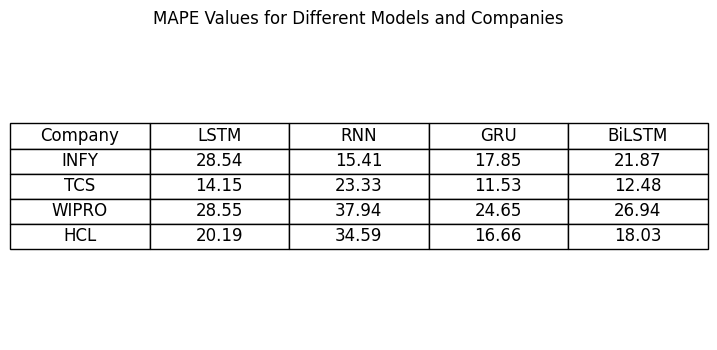

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

# Data
companies = ['INFY', 'TCS', 'WIPRO', 'HCL']
mape_lstm = [28.54, 14.15, 28.55, 20.19]
mape_rnn = [15.41, 23.33, 37.94, 34.59]
mape_gru = [17.85, 11.53, 24.65, 16.66]
mape_bilstm = [21.87, 12.48, 26.94, 18.03]

# Create DataFrame with 'Company' column
data = {
    'Company': companies,
    'LSTM': mape_lstm,
    'RNN': mape_rnn,
    'GRU': mape_gru,
    'BiLSTM': mape_bilstm
}
df = pd.DataFrame(data)

# Plotting the table
fig, ax = plt.subplots(figsize=(6, 4))  # Set figure size larger for better zoom
ax.axis('tight')
ax.axis('off')

# Create the table
table = ax.table(cellText=df.values, 
                 colLabels=df.columns, 
                 cellLoc='center', 
                 loc='center')

table.scale(1.5, 1.5)  # Scale the table for better readability
table.auto_set_font_size(False)
table.set_fontsize(12)  # Increase font size

plt.title('MAPE Values for Different Models and Companies')
plt.show()


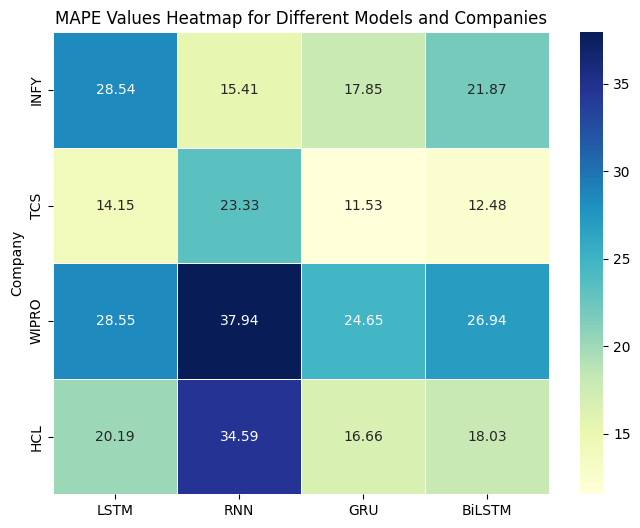

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Data
companies = ['INFY', 'TCS', 'WIPRO', 'HCL']
mape_lstm = [28.54, 14.15, 28.55, 20.19]
mape_rnn = [15.41, 23.33, 37.94, 34.59]
mape_gru = [17.85, 11.53, 24.65, 16.66]
mape_bilstm = [21.87, 12.48, 26.94, 18.03]

# Create DataFrame with 'Company' column
data = {
    'Company': companies,
    'LSTM': mape_lstm,
    'RNN': mape_rnn,
    'GRU': mape_gru,
    'BiLSTM': mape_bilstm
}
df = pd.DataFrame(data)

# Set the 'Company' column as the index for better heatmap display
df.set_index('Company', inplace=True)

# Plotting the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(df, annot=True, fmt=".2f", cmap="YlGnBu", cbar=True, linewidths=.5)

plt.title('MAPE Values Heatmap for Different Models and Companies')
plt.show()
